# Image Generation with OpenVINO GenAI

## Install dependencies

In [ ]:
!pip install openvino-genai optimum-intel nncf huggingface diffusers --extra-index-url https://download.pytorch.org/whl/cpu

## Download and convert LCM model

In [ ]:
from optimum.exporters.openvino.convert import export_tokenizer
from optimum.intel import OVPipelineForText2Image

lcm_output_dir = "models/dreamshaper-v7-lcm"

pipeline = OVPipelineForText2Image.from_pretrained("SimianLuo/LCM_Dreamshaper_v7", export=True)
pipeline.save_pretrained(lcm_output_dir)
export_tokenizer(pipeline.tokenizer, lcm_output_dir + "/tokenizer")

## Query devices

In [3]:
import openvino as ov

core = ov.Core()
available_devices = core.available_devices

print(available_devices)
print([core.get_property(device, "FULL_DEVICE_NAME") for device in available_devices])

['CPU', 'GPU', 'NPU']
['Intel(R) Core(TM) Ultra 7 258V', 'Intel(R) Arc(TM) Graphics (iGPU)', 'Intel(R) AI Boost']


In [4]:
import ipywidgets as widgets

# Select the model type
device_dropdown = widgets.Dropdown(
    options=available_devices,
    value="CPU",
    description="Inference device:"
)
device_dropdown

Dropdown(description='Inference device:', options=('CPU', 'GPU', 'NPU'), value='CPU')

## Run inference

In [5]:
import openvino_genai as ov_genai

lcm_pipe = ov_genai.Text2ImagePipeline(lcm_output_dir, device_dropdown.value)

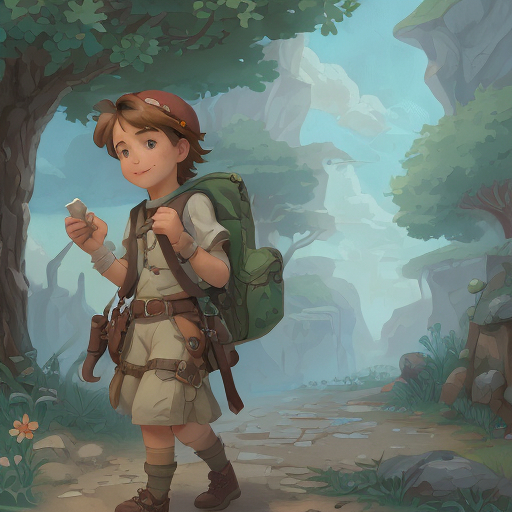

In [6]:
import numpy as np
from PIL import Image

prompt = "Cartoon-style adventurer child with a backpack and a treasure map"

steps = 8
seed = np.random.randint(2**32)
image_tensor = lcm_pipe.generate(prompt, rng_seed=seed, width=512, height=512, num_inference_steps=steps, num_images_per_prompt=1)

image = Image.fromarray(image_tensor.data[0])
image

In [7]:
print(f"Inference time: {lcm_pipe.get_performance_metrics().get_inference_duration():.2f} ms")
print(f"{steps} steps, one step time: {lcm_pipe.get_performance_metrics().get_iteration_duration().mean:.2f} ms")

Inference time: 4392.19 ms
8 steps, one step time: 304.03 ms


## Download preconverted and preoptimized Flux model

In [ ]:
from huggingface_hub import snapshot_download

flux_output_dir = "models/flux.1-schnell"
snapshot_download("OpenVINO/FLUX.1-schnell-int4-ov", local_dir=flux_output_dir, resume_download=True)

In [9]:
import openvino_genai as ov_genai

flux_pipe = ov_genai.Text2ImagePipeline(flux_output_dir, device_dropdown.value)

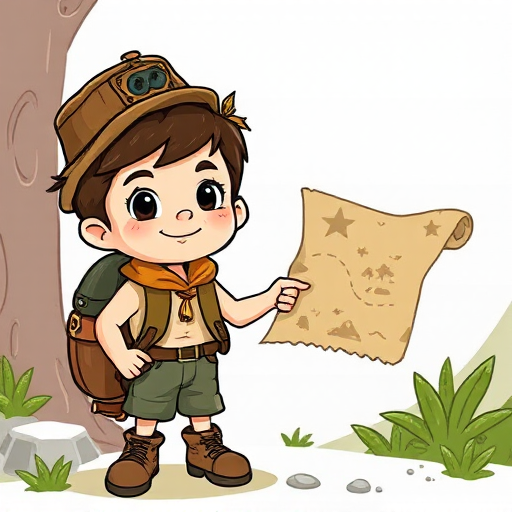

In [10]:
import numpy as np
from PIL import Image

prompt = "Cartoon-style adventurer child with a backpack and a treasure map"

steps = 4
seed = np.random.randint(2**32)
image_tensor = flux_pipe.generate(prompt, rng_seed=seed, width=512, height=512, num_inference_steps=steps, num_images_per_prompt=1)

image = Image.fromarray(image_tensor.data[0])
image

In [11]:
print(f"Inference time: {flux_pipe.get_performance_metrics().get_inference_duration():.2f} ms")
print(f"{steps} steps, one step time: {flux_pipe.get_performance_metrics().get_iteration_duration().mean:.2f} ms")

Inference time: 11345.83 ms
4 steps, one step time: 2058.41 ms
